In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import numpy as np
import pandas as pd
import os
import datetime as dt
from flask import Flask
import matplotlib.pyplot as plt

In [2]:
hawaii_db = os.path.join("Resources", "hawaii.sqlite")
engine = create_engine(f"sqlite:///{hawaii_db}")

In [3]:
Base = automap_base()

In [4]:
Base.prepare(engine, reflect=True)

In [5]:
Base.classes.keys()

['measurement', 'station']

In [6]:
measurement = Base.classes.measurement

station = Base.classes.station

In [7]:
session = Session(engine)

In [8]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
[column['name'] for column in columns]

['id', 'station', 'date', 'prcp', 'tobs']

In [9]:
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [10]:
a_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(a_year_ago)

2016-08-23


In [11]:
select = [measurement.date, measurement.prcp]

In [12]:
select_join = session.query(*select).filter(measurement.date > a_year_ago).all()
#select_join

In [13]:
select_df = pd.DataFrame(select_join, columns=['date', 'prcp']).set_index("date").sort_values(["date"], ascending=True)
select_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


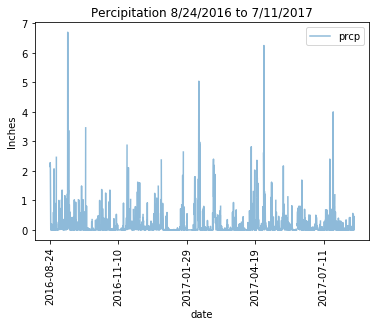

In [14]:
select_plot= select_df.plot(rot=90, alpha = 0.5)
select_plot.set_title("Percipitation 8/24/2016 to 7/11/2017")
select_plot.set_ylabel("Inches")
plt.savefig("Graphs/Precipitation graph.png")

In [15]:
select_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
select_next = [station.station]
stat_count = session.query(station.station).count()
print(stat_count)

9


In [17]:
select_stat = [measurement.station,func.count(measurement.station)]
most_active = session.query(*select_stat).group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
low_high_avg = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
temp = session.query(*low_high_avg).filter(measurement.station == "USC00519281").all()
temp

[(54.0, 85.0, 71.66378066378067)]

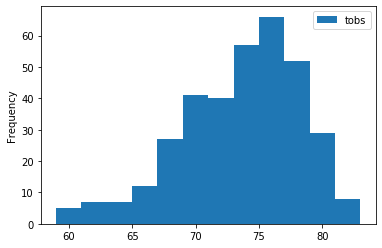

In [19]:
select_tobs = [measurement.tobs]
stat_query = session.query(*select_tobs).filter(measurement.station == "USC00519281").\
    filter(measurement.date > a_year_ago).all()

stat_df = pd.DataFrame(stat_query)
stat_df.plot(kind="hist", bins=12)
plt.savefig("Graphs/Temp Frequency.png")

In [20]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
trip_data = calc_temps('2012-02-28', '2012-03-05')
trip_data

[(62.0, 69.57142857142857, 74.0)]

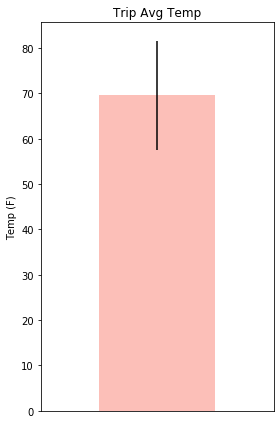

In [22]:
trip_df = pd.DataFrame(trip_data, columns=['tmin', 'tavg', 'tmax'])

trip_df.plot.bar(y='tavg', yerr=(trip_df['tmax'] - trip_df['tmin']), title='Trip Avg Temp', color='salmon', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Graphs/TripAvgTemp.png")
plt.show()

In [23]:
def precipitation(start_date, end_date):
    select_column = [measurement.station, 
               station.name, 
               station.latitude, 
               station.longitude, 
               station.elevation, 
               measurement.prcp]

    return session.query(*select_column).filter(measurement.station == station.station).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).\
        group_by(measurement.station).order_by(measurement.prcp.desc()).all()
print(precipitation('2012-02-28','2012-03-05'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.4), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.05), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, None)]
